In [187]:
# Importing Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import chardet
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols, logit
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [151]:
# Importing data into notebook
sourcepath = 'D:\Work\Research\Dropbox\Machine Learning\Side Projects\Employee Churn IBM\employee_churn_prediction_ibm'
filepath = os.path.join(sourcepath, "data", "processed", "IBM_HR_Data_Cleaned.csv")

IBMData = pd.read_csv(filepath)

In [152]:
# Checking data head
IBMData.head(n=5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41.0,Yes,Travel_Rarely,1102.0,Sales,1.0,2,Life Sciences,1,2,...,3,1,0,8.0,0.0,1,6.0,4.0,0.0,5.0
1,49.0,No,Travel_Frequently,279.0,Research & Development,8.0,1,Life Sciences,2,3,...,4,4,1,10.0,3.0,3,10.0,7.0,1.0,7.0
2,37.0,Yes,Travel_Rarely,1373.0,Research & Development,2.0,2,Other,4,4,...,3,2,0,7.0,3.0,3,0.0,0.0,0.0,0.0
3,33.0,No,Travel_Frequently,1392.0,Research & Development,3.0,4,Life Sciences,5,4,...,3,3,0,8.0,3.0,3,8.0,7.0,3.0,0.0
4,27.0,No,Travel_Rarely,591.0,Research & Development,2.0,1,Medical,7,1,...,3,4,1,6.0,3.0,3,2.0,2.0,2.0,2.0


In [153]:
# Checking variables in the IBM Data 
IBMData.dtypes

Age                         float64
Attrition                    object
BusinessTravel               object
DailyRate                   float64
Department                   object
DistanceFromHome            float64
Education                     int64
EducationField               object
EmployeeNumber                int64
EnvironmentSatisfaction       int64
Gender                       object
HourlyRate                  float64
JobInvolvement                int64
JobLevel                      int64
JobRole                      object
JobSatisfaction               int64
MaritalStatus                object
MonthlyIncome               float64
MonthlyRate                 float64
NumCompaniesWorked          float64
OverTime                     object
PercentSalaryHike           float64
PerformanceRating             int64
RelationshipSatisfaction      int64
StockOptionLevel              int64
TotalWorkingYears           float64
TrainingTimesLastYear       float64
WorkLifeBalance             

In [154]:
# Remove the column 'EmployeeNumber' since this identifies each employee by a unique number and each employee appears only once 
IBMData.drop(['EmployeeNumber'], axis = 1, inplace = True)

In [155]:
# Then make sure that some of the important variables are in float form, even if they have an int64 type
numvars = ['Age','DailyRate','DistanceFromHome','HourlyRate','MonthlyIncome','MonthlyRate','NumCompaniesWorked', 
          'PercentSalaryHike','PerformanceRating','TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany',
          'YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager']
IBMData[numvars] = IBMData[numvars].apply(pd.to_numeric, axis = 1, downcast = 'float') 

# Now generate a binary indicator for the attrition variable
IBMData['Left'] = (IBMData.Attrition=='Yes')*1

# Now convert the remaining variables into categorical variables/object variables
catvars = [item for item in IBMData.columns.to_list() if item not in numvars and item != 'Attrition' and item != 'Left']
IBMData[catvars] = IBMData[catvars].astype('category')

# Now remove the attrition variable
IBMData.drop(['Attrition'], axis = 1, inplace = True)

In [156]:
# Check data types of columns again
IBMData.dtypes

Age                          float32
BusinessTravel              category
DailyRate                    float32
Department                  category
DistanceFromHome             float32
Education                   category
EducationField              category
EnvironmentSatisfaction     category
Gender                      category
HourlyRate                   float32
JobInvolvement              category
JobLevel                    category
JobRole                     category
JobSatisfaction             category
MaritalStatus               category
MonthlyIncome                float32
MonthlyRate                  float32
NumCompaniesWorked           float32
OverTime                    category
PercentSalaryHike            float32
PerformanceRating            float32
RelationshipSatisfaction    category
StockOptionLevel            category
TotalWorkingYears            float32
TrainingTimesLastYear        float32
WorkLifeBalance             category
YearsAtCompany               float32
Y

In [157]:
# Now split the data into X and Y
Y = IBMData.Left.copy(deep=True)
X = IBMData.loc[:, IBMData.columns != 'Left'].copy(deep = True)
print('Shapes of the dependent and independent variables respectively: ', Y.shape, X.shape)

Shapes of the dependent and independent variables respectively:  (1470,) (1470, 30)


In [158]:
# Now change levels in some categorical variables to shorter or more interpretable names

X['BusinessTravel'].cat.rename_categories(
    {'Travel_Rarely':'TravelRare','Travel_Frequently':'TravelFreq','Non-Travel':'TravelNo'}, inplace = True)
X['Department'].cat.rename_categories(
    {'Research & Development':'R&D','Sales':'Sales','Human Resources':'HR'}, inplace = True)
X['EducationField'].cat.rename_categories(
    {'Life Sciences':'LifeSc','Technical Degree':'Technical','Human Resources':'EducHR'}, inplace = True)
X['JobRole'].cat.rename_categories(
    {'Sales Executive':'SalexExec','Research Scientist':'Scientist','Laboratory Technician':'LabTech',
    'Manufacturing Director':'ManufDir','Healthcare Representative':'HealthRep','Sales Representative':'SalesRep',
    'Research Director':'ResDir','Human Resources':'RoleHR'}, inplace = True)

In [159]:
# Now convert categorical variables into dummies and then drop one base level 
Xnumvars = X[[item for item in X.columns.to_list() if X[item].dtypes == 'float32']]
Xcatvars = X[[item for item in X.columns.to_list() if hasattr(X[item], 'cat')]]  

# Now generate the dummies
Xcatvars = pd.get_dummies(data = Xcatvars, drop_first = False)
# Now drop the base levels by selecting an appropriate base level
Xcatvars.drop(['BusinessTravel_TravelNo','Department_HR','Education_1','EducationField_Other','EnvironmentSatisfaction_1',
              'Gender_Female','JobInvolvement_1','JobLevel_1','JobSatisfaction_1','JobRole_RoleHR','MaritalStatus_Single',
              'OverTime_No','RelationshipSatisfaction_1','StockOptionLevel_0','WorkLifeBalance_1'], axis = 1, inplace = True)

# Now bind the datasets together
X1 = pd.concat([Xnumvars, Xcatvars], axis = 1)

### (1) Linear Probability Model Regressions

#### (1.a) LPM Regressions with no interaction variables

Estimated Coefficients from Linear Probability Model with No Interaction Terms:
                    Coefficients
Age                    -0.003650
DailyRate              -0.000034
DistanceFromHome        0.003958
HourlyRate             -0.000094
MonthlyIncome          -0.000010
...                          ...
StockOptionLevel_3     -0.048175
WorkLifeBalance_2      -0.118201
WorkLifeBalance_3      -0.155609
WorkLifeBalance_4      -0.106715
Constant                0.754617

[63 rows x 1 columns]
R-squared value of the fitted mode: 0.29920117274299185


Text(0.5, 0, 'Residuals')

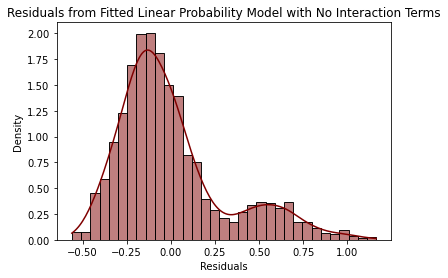

In [160]:
# Create Model Object
LPM_NoInteract = LinearRegression()

# Fit the model to the data
LPM_NoInteract.fit(X1,Y)

# Print the intercept and the model parameters
LPM_NoInteract_Coefs = pd.DataFrame(np.append(LPM_NoInteract.coef_,LPM_NoInteract.intercept_), 
                                    index = X1.columns.to_list()+['Constant'], 
                                    columns = ['Coefficients'])
print('Estimated Coefficients from Linear Probability Model with No Interaction Terms:')
print(LPM_NoInteract_Coefs) 

# Printing the R-squared value
print('R-squared value of the fitted mode:', LPM_NoInteract.score(X1,Y))

# To predict using this model
#LPM_NoInteract.predict(TestX)

# To find the residuals of this model
residuals = Y - LPM_NoInteract.predict(X1)
# Plot the residuals in a histogram
g = sns.histplot(residuals, stat = 'density', kde = True, color = 'maroon')
g.set_title('Residuals from Fitted Linear Probability Model with No Interaction Terms')
g.set_xlabel('Residuals')

In [161]:
## Implementing LPM Alternatively Using StatsModels Package

# Add a constant
X_SM = sm.add_constant(X1)
LPM_NoInteract_SM = sm.OLS(Y,X_SM).fit()

print('Summary of model fit:')
print(LPM_NoInteract_SM.summary())

# Finding all the attritbute names in the model results
for attr in dir(LPM_NoInteract_SM):
    if not attr.startswith('_'):
        print(attr)

Summary of model fit:
                            OLS Regression Results                            
Dep. Variable:                   Left   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     9.712
Date:                Thu, 25 Feb 2021   Prob (F-statistic):           6.08e-72
Time:                        19:38:23   Log-Likelihood:                -353.44
No. Observations:                1470   AIC:                             832.9
Df Residuals:                    1407   BIC:                             1166.
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [163]:
X.columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [179]:
## Alternative Way of Implementing Linear Regression Replicating R-style formula

# Define the formula first
formula = ('Left ~ Age + DailyRate + DistanceFromHome + HourlyRate + MonthlyIncome + MonthlyRate + NumCompaniesWorked + ' +
          'PercentSalaryHike + PerformanceRating + TotalWorkingYears + TrainingTimesLastYear + YearsAtCompany + ' +
          'YearsInCurrentRole + YearsSinceLastPromotion + YearsWithCurrManager + ' + 
          'C(BusinessTravel, Treatment(reference = "TravelNo")) + C(Department, Treatment(reference = "HR")) + ' + 
          'C(Education, Treatment(reference = 1)) + C(EducationField, Treatment(reference = "EducHR")) + ' + 
          'C(EnvironmentSatisfaction, Treatment(reference = 1)) + C(Gender, Treatment(reference="Female")) + ' +
          'C(JobInvolvement, Treatment(reference = 1)) + C(JobLevel, Treatment(reference=1)) + ' + 
          'C(JobSatisfaction, Treatment(reference=1)) + C(JobRole, Treatment(reference="RoleHR")) + ' + 
          'C(MaritalStatus, Treatment(reference="Single")) + C(OverTime, Treatment(reference="No")) + ' + 
          'C(RelationshipSatisfaction, Treatment(reference=1)) + C(StockOptionLevel, Treatment(reference=0)) + ' + 
          'C(WorkLifeBalance, Treatment(reference=1))')  

LPM_NoInteract_SMF = smf.ols(data = pd.concat([Y,X], axis = 1), formula = formula).fit()

print('Estimated Coefficients and Other Details:')
print(LPM_NoInteract_SMF.summary())

# Finding all the attritbute names in the model results
for attr in dir(LPM_NoInteract_SM):
    if not attr.startswith('_'):
        print(attr)

Estimated Coefficients and Other Details:
                            OLS Regression Results                            
Dep. Variable:                   Left   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     9.712
Date:                Thu, 25 Feb 2021   Prob (F-statistic):           6.08e-72
Time:                        20:02:24   Log-Likelihood:                -353.44
No. Observations:                1470   AIC:                             832.9
Df Residuals:                    1407   BIC:                             1166.
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [222]:
## Checking for multicollinearity among independent variables using Variance Inflation Factor (VIF)

## Do the following:
# First, compute the VIF for all numeric variables in the data
# Second, order these VIF values from largest to smallest and get rid of the largest. 
# Third, drop the variable with largest VIF if the largest VIF >= 10
# Fourth, repeat steps 1-3 till largest VIF value < 10

largestVIF = 11.
Xalt = X[[item for item in X.columns.to_list() if X[item].dtypes == 'float32']].copy(deep=True)
while(largestVIF >= 10.):
    VIF = pd.DataFrame()
    VIF['Variables'] = Xalt.columns
    VIF['VIF'] = [variance_inflation_factor(Xalt.values, i) for i in range(Xalt.shape[1])]
    largestVIF = max(VIF['VIF'])
    if(largestVIF >= 10.):
        Xalt.drop([VIF.Variables[VIF['VIF'].idxmax()]], axis = 1, inplace = True)
        print('Largest VIF value >= 10.0')
        print('Dropping Variable: '+ str(VIF.Variables[VIF['VIF'].idxmax()]))

print()        
print('Final List of Numeric Variables Remaining in Data:')        
print(Xalt.columns.to_list())

Largest VIF value >= 10.0
Dropping Variable: PerformanceRating
Largest VIF value >= 10.0
Dropping Variable: Age
Largest VIF value >= 10.0
Dropping Variable: PercentSalaryHike
Largest VIF value >= 10.0
Dropping Variable: TotalWorkingYears

Final List of Numeric Variables Remaining in Data:
['DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [223]:
# Reconstructing X using the remaining numeric variables and the categorical variables
# Important categorical variables to include 
catvars2include = ['BusinessTravel','Education','Gender','JobSatisfaction','JobRole','Department', 
                   'OverTime','JobLevel','WorkLifeBalance','StockOptionLevel']
Xalt = pd.concat([Xalt, X[catvars2include]], axis = 1)

In [229]:
## To improve the interpretability of the coefficients and also to improve comparisons of the coefficients across 
## variables conduct a logistic regression which will help estimate the increase in likelihood with each marginal 
## change of the variables. 
formula = ('Left ~ DailyRate + DistanceFromHome + HourlyRate + MonthlyIncome + MonthlyRate + NumCompaniesWorked + ' +
          'TrainingTimesLastYear + YearsAtCompany + ' +
          'YearsInCurrentRole + YearsSinceLastPromotion + YearsWithCurrManager + ' + 
          'C(BusinessTravel, Treatment(reference = "TravelNo")) + C(Department, Treatment(reference = "HR")) + ' + 
          'C(Education, Treatment(reference = 1)) + C(Gender, Treatment(reference="Female")) + ' + 
          'C(JobSatisfaction, Treatment(reference=1)) + C(JobLevel, Treatment(reference=1)) + ' + 
          'C(StockOptionLevel, Treatment(reference=0)) + C(OverTime, Treatment(reference="No")) + ' + 
          'C(WorkLifeBalance, Treatment(reference=1))')

Logit_NoInteract = logit(formula, pd.concat([Xalt, Y], axis = 1)).fit(maxiter = 2000)

# Now print the estimated coefficients from the Logit Model
print('Estimated Coefficients from Logit Model:')
print(Logit_NoInteract.summary())

# Now print the ODDS ratio for each variable
print('ODDs Ratio for each explanatory variable:')
print(round(np.exp(Logit_NoInteract.params),3))

# Now print the marginal effects of each variable at the overall level
AME = Logit_NoInteract.get_margeff(at = 'overall', method = 'dydx') 
print('Average Marginal Effects of Each Variable:')
print(AME.summary())

Optimization terminated successfully.
         Current function value: 0.308528
         Iterations 8
Estimated Coefficients from Logit Model:
                           Logit Regression Results                           
Dep. Variable:                   Left   No. Observations:                 1470
Model:                          Logit   Df Residuals:                     1435
Method:                           MLE   Df Model:                           34
Date:                Thu, 25 Feb 2021   Pseudo R-squ.:                  0.3015
Time:                        23:20:42   Log-Likelihood:                -453.54
converged:                       True   LL-Null:                       -649.29
Covariance Type:            nonrobust   LLR p-value:                 2.333e-62
                                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------

Average Marginal Effects of Each Variable:
        Logit Marginal Effects       
Dep. Variable:                   Left
Method:                          dydx
At:                           overall
                                                                      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
C(BusinessTravel, Treatment(reference="TravelNo"))[T.TravelFreq]     0.1618      0.036      4.492      0.000       0.091       0.232
C(BusinessTravel, Treatment(reference="TravelNo"))[T.TravelRare]     0.0773      0.034      2.278      0.023       0.011       0.144
C(Department, Treatment(reference="HR"))[T.R&D]                     -0.0388      0.038     -1.034      0.301      -0.112       0.035
C(Department, Treatment(reference="HR"))[T.Sales]                    0.0836      0.039      2.127      0.033       0.007       0.161
C(Educa

In [ ]:
# Now sort the average marginal effects by their effects (dydx)
# Then plot the absolute largest 5 and absolute smallest 5 effects
# Keep in mind that these effects show how much the probability of leaving will change 

